In [3]:
import pandas as pd
import numpy as np

# In this project we will build a model to estimate current credit status of a customer. 

In most applications, we would like to *predict* probability of default for a customer in the future, but we don't have data for that.

In [4]:
# this is to read data on Google Drive
from google.colab import drive
drive.mount("/content/drive")

ModuleNotFoundError: No module named 'google.colab'

In [6]:
# You can find the data here: https://www.kaggle.com/wordsforthewise/lending-club
data=pd.read_csv("accepted.csv")

/Applications/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


# Steps:
1. Data Exploration - understand the data
2. Preliminary feature exclusion - remove features that do not make sense, or can not be used
3. Observation exclusion - to creat an unbiased sample that represents the target population and serves model's goal
4. Missing Value Imputation (not needed for the XGBoost package we use)
5. One-Hot Encoding
6. Normalization (not needed for tree-based models)
7. Outlier Treatment (not needed for tree-based models)
8. Feature Engineering (not needed for this model)
9. Test/Train split
10. Feature reduction
11. Grid search, and Bias/Variance analysis - Choose the final model


## 1. Data Exploration - the goal here is to know the data better

**Note: This is a demo. Analysis has been done on only some of the attributes. In an actual project, all attributes, that make sense, should be analyzed.**

In [7]:
data.shape

(2260701, 151)

In [8]:
data.tail(5)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
2260696,88985880,NaN,40000.0,40000.0,40000.0,60 months,10.49,859.56,B,B3,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2260697,88224441,NaN,24000.0,24000.0,24000.0,60 months,14.49,564.56,C,C4,...,NaN,NaN,Cash,Y,Mar-2019,ACTIVE,Mar-2019,10000.0,44.82,1.0
2260698,88215728,NaN,14000.0,14000.0,14000.0,60 months,14.49,329.33,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2260699,Total amount funded in policy code 1: 1465324575,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2260700,Total amount funded in policy code 2: 521953170,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# remove invalid observations
data = data[0:2260699]

In [10]:
# frequently check your steps
print (data.shape[0])
data.tail(2)

2260699


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
2260697,88224441,NaN,24000.0,24000.0,24000.0,60 months,14.49,564.56,C,C4,...,NaN,NaN,Cash,Y,Mar-2019,ACTIVE,Mar-2019,10000.0,44.82,1.0
2260698,88215728,NaN,14000.0,14000.0,14000.0,60 months,14.49,329.33,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
# check data types - objects imply non-numeric
# note that sometimes numeric columns appear as Object, because of few non-numeric observations. Such as a character that may represent a special value.
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
    print(data.dtypes)

id                                             object
member_id                                     float64
loan_amnt                                     float64
funded_amnt                                   float64
funded_amnt_inv                               float64
term                                           object
int_rate                                      float64
installment                                   float64
grade                                          object
sub_grade                                      object
emp_title                                      object
emp_length                                     object
home_ownership                                 object
annual_inc                                    float64
verification_status                            object
issue_d                                        object
loan_status                                    object
pymnt_plan                                     object
url                         

## 2. Preliminary feature exclusion

Exclude features that do not make sense or can not be used. For example, some features such as Gender can not be used in a Credit Risk model (fair lending practices).  What other features you can think of that can not be used?

Here we will use a small subsample of features. In an actual project, more features would have been selected.

ID will be used for data merge (needed in an actual project), loan_status will be used to define dependent variable, pymnt_plan and hardship_flag will be used to define exclusions. The rest of the variables will be used as independent variables.

In [12]:
final_data = data[["id", "emp_length", "loan_status", "pymnt_plan", "dti", "delinq_2yrs"
,"fico_range_low", "fico_range_high", "inq_last_6mths", "mths_since_last_delinq", "revol_bal",
"revol_util", "total_acc", "avg_cur_bal", "chargeoff_within_12_mths", "hardship_flag"]].copy()

In [13]:
# check the data frequently
final_data.shape

(2260699, 16)

In [14]:
# check the data frequently
final_data.tail(5)

,id,emp_length,loan_status,pymnt_plan,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,revol_bal,revol_util,total_acc,avg_cur_bal,chargeoff_within_12_mths,hardship_flag
2260694,89885898,7 years,Current,n,19.61,0.0,665.0,669.0,0.0,NaN,49431.0,84.4,54.0,26106.0,0.0,N
2260695,88977788,10+ years,Current,n,34.94,0.0,695.0,699.0,1.0,60.0,21665.0,39.0,58.0,6369.0,0.0,N
2260696,88985880,9 years,Current,n,12.75,7.0,705.0,709.0,1.0,9.0,8633.0,64.9,37.0,5680.0,0.0,N
2260697,88224441,6 years,Charged Off,n,18.30,0.0,660.0,664.0,0.0,67.0,17641.0,68.1,31.0,6243.0,0.0,N
2260698,88215728,10+ years,Current,n,23.36,0.0,660.0,664.0,1.0,37.0,7662.0,54.0,22.0,17883.0,0.0,N


## 3. Observation Exclusion

In [15]:
final_data.dtypes

id                           object
emp_length                   object
loan_status                  object
pymnt_plan                   object
dti                         float64
delinq_2yrs                 float64
fico_range_low              float64
fico_range_high             float64
inq_last_6mths              float64
mths_since_last_delinq      float64
revol_bal                   float64
revol_util                  float64
total_acc                   float64
avg_cur_bal                 float64
chargeoff_within_12_mths    float64
hardship_flag                object
dtype: object

In [16]:
# Remove observations under payment plan. Cases that are under payment plan, do not follow normal delinquency process. They often have weak profiles but are not tagged as
# delinquent because they are under payment plan.

final_data[["pymnt_plan", "id"]].groupby(["pymnt_plan"]).count()

,id
pymnt_plan,
n,2260048
y,620


In [17]:
final_data = final_data[final_data.pymnt_plan != "y"]
final_data.shape[0]

2260079

In [18]:
# Remove observations under hardship flag, for the same reason as hardship flag.

final_data[["hardship_flag", "id"]].groupby(["hardship_flag"]).count()

,id
hardship_flag,
N,2259836
Y,212


In [19]:
final_data = final_data[final_data.hardship_flag != "Y"]
final_data.shape[0]

2259867

In [20]:
# Last exclusions are related to the target variable. We intend to analyze the current credit status of customer, so we exclude inactive accounts.
# One category of inactive is "charged off" accounts. These are customers who have defaulted previously, and so we have stopped tracking their credit
# status (target variable). Their profile (independent variables) may have improved since they have been charged off, but the target variable 
# shows "charged off". Therefore for these customers, dependent and independent variables do not show the correct relationship.

final_data[["loan_status", "id"]].groupby(["loan_status"]).count()

,id
loan_status,
Charged Off,268559
Current,878313
Default,40
Does not meet the credit policy. Status:Charged Off,761
Does not meet the credit policy. Status:Fully Paid,1988
Fully Paid,1076751
In Grace Period,8420
Late (16-30 days),4266
Late (31-120 days),20738


In [21]:
# Remove cases with missing loan status as well as inactive accounts. 
# Note that we often don't do missing imputation on Y variable. rather exclude those observations.
final_data = final_data[final_data.loan_status != "Charged Off"]
final_data = final_data[final_data.loan_status != "Default"]
final_data = final_data[final_data.loan_status != "Does not meet the credit policy. Status:Charged Off"]
final_data = final_data[final_data.loan_status != "Does not meet the credit policy. Status:Fully Paid"]
final_data = final_data[final_data.loan_status != "Fully Paid"]
final_data = final_data[final_data.loan_status.notnull()]

final_data.shape[0]

911737

In [22]:
# check
final_data[["loan_status", "id"]].groupby(["loan_status"]).count()

,id
loan_status,
Current,878313
In Grace Period,8420
Late (16-30 days),4266
Late (31-120 days),20738


In [23]:
# Define target variable based on "loan_status". We define everyone who is current or in grace priod as good (0), and others as bad (1).
final_data['30+ Delinquent'] = np.where((final_data.loan_status == "Current") | 
                                        (final_data.loan_status == "In Grace Period"),0, 1)

In [24]:
# check
final_data[["30+ Delinquent", "id"]].groupby(["30+ Delinquent"]).count()

,id
30+ Delinquent,
0,886733
1,25004


In [25]:
# remove attributes that are not needed anymore
final_data.drop(['loan_status', 'hardship_flag', 
                'pymnt_plan'], axis=1, inplace=True)

# 4. Missing value imputation

In [26]:
# Missing value imputation is not needed for the XGBoost package we use. It will handle missing values automatically. 
# We just need to make sure all missing values are stored as NAN. 
final_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
dti,910401.0,19.637414,17.711089,0.0,12.06,18.2,25.19,999.0
delinq_2yrs,911737.0,0.290833,0.850977,0.0,0.00,0.0,0.00,58.0
fico_range_low,911737.0,702.182378,34.343632,660.0,675.00,695.0,720.00,845.0
fico_range_high,911737.0,706.182657,34.344794,664.0,679.00,699.0,724.00,850.0
inq_last_6mths,911737.0,0.450582,0.745594,0.0,0.00,0.0,1.00,6.0
mths_since_last_delinq,433539.0,34.922791,21.852483,0.0,17.00,32.0,50.00,195.0
revol_bal,911737.0,17231.894560,23618.181163,0.0,5973.00,11631.0,21019.00,2559552.0
revol_util,910833.0,48.155078,24.821209,0.0,28.90,47.4,67.00,191.0
total_acc,911737.0,22.959383,11.861111,2.0,14.00,21.0,29.00,165.0
avg_cur_bal,911689.0,13630.347869,16728.755863,0.0,3051.00,7235.0,18877.00,752994.0


In [27]:
# 999 in "dti" sounds like a missing value. Convert it to NAN.
final_data['dti'].replace(999, np.NaN, inplace = True)
final_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
dti,910304.0,19.533055,14.543042,0.0,12.06,18.2,25.18,995.6
delinq_2yrs,911737.0,0.290833,0.850977,0.0,0.00,0.0,0.00,58.0
fico_range_low,911737.0,702.182378,34.343632,660.0,675.00,695.0,720.00,845.0
fico_range_high,911737.0,706.182657,34.344794,664.0,679.00,699.0,724.00,850.0
inq_last_6mths,911737.0,0.450582,0.745594,0.0,0.00,0.0,1.00,6.0
mths_since_last_delinq,433539.0,34.922791,21.852483,0.0,17.00,32.0,50.00,195.0
revol_bal,911737.0,17231.894560,23618.181163,0.0,5973.00,11631.0,21019.00,2559552.0
revol_util,910833.0,48.155078,24.821209,0.0,28.90,47.4,67.00,191.0
total_acc,911737.0,22.959383,11.861111,2.0,14.00,21.0,29.00,165.0
avg_cur_bal,911689.0,13630.347869,16728.755863,0.0,3051.00,7235.0,18877.00,752994.0


# 5. One Hot Encoding

In [28]:
# there is only one independent non-numerical variable we need to take care of: emp_length
final_data.dtypes

id                           object
emp_length                   object
dti                         float64
delinq_2yrs                 float64
fico_range_low              float64
fico_range_high             float64
inq_last_6mths              float64
mths_since_last_delinq      float64
revol_bal                   float64
revol_util                  float64
total_acc                   float64
avg_cur_bal                 float64
chargeoff_within_12_mths    float64
30+ Delinquent                int64
dtype: object

In [29]:
# check categories
final_data[["emp_length", "id"]].groupby(["emp_length"]).count()

,id
emp_length,
1 year,59515
10+ years,305044
2 years,81494
3 years,72808
4 years,55799
5 years,55320
6 years,39719
7 years,32943
8 years,31072


In [30]:
# we can do one-hot encoding on "employment length", but it is an ordinal, not categorical, variable. So we can just convert it to ordinal numbers.
final_data['Employment_Length'] = np.nan
final_data['Employment_Length'] = np.where(final_data.emp_length == "< 1 year", 0, final_data.Employment_Length)
final_data['Employment_Length'] = np.where(final_data.emp_length == "1 year", 1, final_data.Employment_Length)
final_data['Employment_Length'] = np.where(final_data.emp_length == "2 years", 2, final_data.Employment_Length)
final_data['Employment_Length'] = np.where(final_data.emp_length == "3 years", 3, final_data.Employment_Length)
final_data['Employment_Length'] = np.where(final_data.emp_length == "4 years", 4, final_data.Employment_Length)
final_data['Employment_Length'] = np.where(final_data.emp_length == "5 years", 5, final_data.Employment_Length)
final_data['Employment_Length'] = np.where(final_data.emp_length == "6 years", 6, final_data.Employment_Length)
final_data['Employment_Length'] = np.where(final_data.emp_length == "7 years", 7, final_data.Employment_Length)
final_data['Employment_Length'] = np.where(final_data.emp_length == "8 years", 8, final_data.Employment_Length)
final_data['Employment_Length'] = np.where(final_data.emp_length == "9 years", 9, final_data.Employment_Length)
final_data['Employment_Length'] = np.where(final_data.emp_length == "10+ years", 10, final_data.Employment_Length)

In [31]:
# check
final_data[["Employment_Length", "id"]].groupby(["Employment_Length"]).count()

,id
Employment_Length,
0.0,81368
1.0,59515
2.0,81494
3.0,72808
4.0,55799
5.0,55320
6.0,39719
7.0,32943
8.0,31072


In [32]:
final_data.drop(['emp_length'], axis=1, inplace=True)

# 6. Normalization - not needed for tree-based models

# 7. Outlier treatment - not needed for tree-based models

# 8. Feature Engineering - not needed for this model




# 9. Test-Train split

In [33]:
# put 30% in test. This is a random split which is not ideal. Ideally we would like to split based on another variable, for example time. 
# Note that both test and train should be unbiased samples of the whole population.
from sklearn.model_selection import train_test_split
train, test = train_test_split(final_data, test_size=0.3)

In [34]:
# check
train.shape

(638215, 14)

In [35]:
# check - it is a good practice to compare test and train samples to make sure they are not fundamentally different. 
# If so, we will get high variance even with a non-overfitted model.
# Here we compare bad rate in both samples.
print (sum(train["30+ Delinquent"])/len(train["30+ Delinquent"]))
print (sum(test["30+ Delinquent"])/len(test["30+ Delinquent"]))

0.027504837711429534
0.027237297182676347


# 10. Feature Selection

Before grid search, we should choose only a sub-sample of features that have predictive power. This will significantly increase speed of grid search, while we don't lose a lot of information. 

There are several ways to do feature reduction. One good approach is to buid a simple Ensemble model, and choose only features with feature importance higher than say 1%. There is no written prescription here, and it is up to modeler to choose the treshold.

Note: Here we have few X variables. Feature selection is really not needed. It is done only for illustration.

Note: For linear models, there are automated feature selection techniques (forward, backward, and stepwise), But even for those, it is beneficial to remove non-important features first, using this approach.

Note: There are several techniques for feature selection (like for all other steps we discussed here). The discussion here is just an example.

In [36]:
# Define X and Y varibales to build the ensemble model. 
X_train = train.drop(["id", '30+ Delinquent'], axis = 1)
Y_train = train['30+ Delinquent']

X_test = test.drop(["id", '30+ Delinquent'], axis = 1)
Y_test = test['30+ Delinquent']

In [37]:
import xgboost as xgb

In [38]:
# run XGBoost

xgb_instance = xgb.XGBClassifier() # nothing inside paranthesis, meaning we are using default parameters, with 100 trees.

model_for_feature_selection = xgb_instance.fit(X_train, Y_train)

In [39]:
# check the importances - you can also use SHAP values
feature_importance = {'Feature':X_train.columns,'Importance':model_for_feature_selection.feature_importances_}
feature_importance = pd.DataFrame(feature_importance)
feature_importance.sort_values("Importance", inplace=True,ascending=False)
feature_importance

,Feature,Importance
2,fico_range_low,0.192469
4,inq_last_6mths,0.172161
6,revol_bal,0.081210
0,dti,0.076433
9,avg_cur_bal,0.072730
7,revol_util,0.071524
11,Employment_Length,0.070431
5,mths_since_last_delinq,0.068607
10,chargeoff_within_12_mths,0.068470
8,total_acc,0.067299


In [40]:
# choose featires with FI higher than 1%
final_features = feature_importance["Feature"][feature_importance.Importance > 0.01]

X_train = X_train[final_features]
X_test = X_test[final_features]

In [41]:
# check 
X_train.head(2)

,fico_range_low,inq_last_6mths,revol_bal,dti,avg_cur_bal,revol_util,Employment_Length,mths_since_last_delinq,chargeoff_within_12_mths,total_acc,delinq_2yrs
1607485,695.0,0.0,25445.0,20.07,13374.0,70.5,0.0,NaN,0.0,12.0,0.0
476549,685.0,1.0,3294.0,16.91,5185.0,21.5,0.0,NaN,0.0,7.0,0.0


In [42]:
# check
test.head(2)

,id,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,revol_bal,revol_util,total_acc,avg_cur_bal,chargeoff_within_12_mths,30+ Delinquent,Employment_Length
2255624,91158269,14.41,1.0,660.0,664.0,0.0,8.0,13354.0,32.3,29.0,8191.0,0.0,0,10.0
1377572,144870654,36.46,0.0,705.0,709.0,0.0,NaN,18460.0,50.0,29.0,8732.0,0.0,0,3.0


# 11. Grid Search and Bias/Variance analysis

In [43]:
# Here we do grid search only on #trees, and look at the AUC as performance metric.

from sklearn.metrics import roc_auc_score
table = pd.DataFrame(columns = ["Num Trees", "Learning Rate", "AUC Train", "AUC Test"])

row = 0
for num_trees in [1, 2, 10, 20, 50, 100, 200]:
  for LR in [0.01, 0.1]:
    xgb_instance = xgb.XGBClassifier(n_estimators=num_trees, learning_rate = LR)
    model = xgb_instance.fit(X_train, Y_train)

    table.loc[row,"Num Trees"] = num_trees
    table.loc[row,"Learning Rate"] = LR
    table.loc[row,"AUC Train"] = roc_auc_score(train['30+ Delinquent'], model.predict_proba(X_train)[:,1])
    table.loc[row,"AUC Test"] = roc_auc_score(test['30+ Delinquent'], model.predict_proba(X_test)[:,1])

    row = row + 1

table

,Num Trees,Learning Rate,AUC Train,AUC Test
0,1,0.01,0.6102,0.599425
1,1,0.1,0.6102,0.599425
2,2,0.01,0.611146,0.60014
3,2,0.1,0.614028,0.604074
4,10,0.01,0.616441,0.604335
5,10,0.1,0.625054,0.609943
6,20,0.01,0.618693,0.605807
7,20,0.1,0.629936,0.610894
8,50,0.01,0.622294,0.607852
9,50,0.1,0.652485,0.613601


# Final Model Selection 

The model seems stable (low variance) for all #trees, but we see almost no gain on test performance from 100 to 200 trees. We may choose to go with 100 trees and 0.1 Learning Rate.

Note: Choice of best model is often a subjective decision, but we always prefer to go with simpler model if possible.

# Build the final model

In [ ]:
# define Dense matrix for model
xgb_instance = xgb.XGBClassifier(n_estimators=100, learning_rate = 0.1)
final_model = xgb_instance.fit(X_train, Y_train)

In [ ]:
# Rank Ordering
perf_train_data = pd.DataFrame({"Actual": train['30+ Delinquent'], "Prediction": final_model.predict_proba(X_train)[:,1]})
quantiles = list(set(perf_train_data.Prediction.quantile([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])))
quantiles.sort()
quantiles.insert(0,0)
quantiles.insert(len(quantiles),1)

perf_train_data["Score Bins"] = pd.cut(perf_train_data["Prediction"], quantiles)
stat = perf_train_data.groupby("Score Bins")["Actual"].agg(["sum", "count"])
stat["Bad Rate"] = stat["sum"] / stat["count"]
stat

In [ ]:
import matplotlib.pyplot as plt

plt.plot(stat["Bad Rate"])

In [ ]:
perf_test_data = pd.DataFrame({"Actual": test['30+ Delinquent'], "Prediction": final_model.predict_proba(X_test)[:,1]})

perf_test_data["Score Bins"] = pd.cut(perf_test_data["Prediction"], quantiles)
stat = perf_test_data.groupby("Score Bins")["Actual"].agg(["sum", "count"])
stat["Bad Rate"] = stat["sum"] / stat["count"]
stat

In [46]:
df = pd.DataFrame({'Probability of Fraud': [0.001, 0.023, 0.003,0.021 0.001, 0.015 , 0.005, 0.004, 0.009, 0.009, 0.011, 0.032, 0.036, 0.044]})


SyntaxError: invalid syntax (<ipython-input-46-004d1856bf08>, line 1)

In [45]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import matplotlib.pyplot as plt


fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

NameError: name 'y_test' is not defined

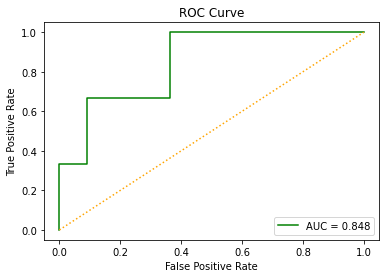

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# True labels and predicted probabilities from Table 8
y_true = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1])
y_pred = np.array([0.001, 0.023, 0.003, 0.021, 0.001, 0.015, 0.005, 0.004, 0.009, 0.009, 0.011, 0.032, 0.036, 0.044])

# Calculate false positive rate (fpr), true positive rate (tpr), and thresholds for ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred)

# Calculate area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, color='green', label=f'AUC = {roc_auc:.3f}')
plt.plot([0, 1], [0, 1], color='orange', linestyle=':')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.savefig("roc.png")
plt.show()